## To run this notebook
- Place the train.pkl file in your google drive path inside /content/gdrive/My Drive/Colab Notebooks/ by creating a directory named *Data* inside it. If you are running on google colab.
- You can use your own data but keep in mind that this notebook will only work for input images of size 64x64, for higher sizes update the generator model. **Remember to place your final pickle file inside Data Directory to run this notebook without changes**
- train.pkl : consists of images that I have cropped to 64x64

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os
import glob
import numpy as np
from sklearn.utils import shuffle
import time
import cv2
import scipy
import pickle
from PIL import Image
import matplotlib.gridspec as gridspec
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Flatten
from keras.layers import Conv2D, Conv2DTranspose, Dropout
from keras.models import Model
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.advanced_activations import LeakyReLU
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import keras.backend as K
#from scipy.interpolate import spline
K.set_image_dim_ordering('tf')
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras.layers import Input, merge
from keras.initializers import RandomNormal
from collections import deque

Using TensorFlow backend.


In [3]:
with open("/content/gdrive/My Drive/Colab Notebooks/Data/train.pkl", 'rb') as f:
  training_data = pickle.load(f)

training_data.shape

(1420, 64, 64, 3)

## Visuallize some images

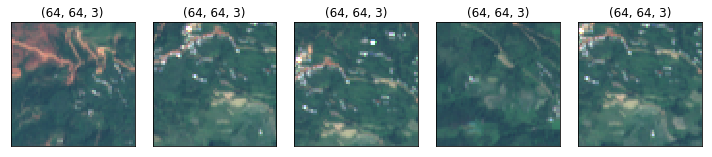

In [4]:
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.subplot(4, 5, i+1)
    plt.imshow(training_data[i])
    plt.title(training_data[i].shape)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## Preprocessing the images

In [0]:
# A function to normalize image pixels.
def norm_img(img):
    '''A function to Normalize Images.
    Input:
        img : Original image as numpy array.
    Output: Normailized Image as numpy array
    '''
    img = (img / 127.5) - 1
    return img

def denorm_img(img):
    '''A function to Denormailze, i.e. recreate image from normalized image
    Input:
        img : Normalized image as numpy array.
    Output: Original Image as numpy array
    '''
    img = (img + 1) * 127.5
    return img.astype(np.uint8) 

def sample_from_dataset(batch_size, image_shape, train_data):
    '''Create a batch of image samples by sampling random images from our training data.
    Normalizes the images.
    Input:
        batch_size : Sample size required
        image_size : Size that Image should be resized to
        train_data : numpy array of our training data

    Output:
        sample : batch of processed images 
    '''
    sample_dim = (batch_size,) + image_shape
    sample = np.empty(sample_dim, dtype=np.float32)
    sample_imgs = np.random.choice(train_data.shape[0], batch_size)
    for index, img in enumerate(sample_imgs):
        image = norm_img(img)
        sample[index,...] = image
    return sample

## Implementing DCGAN

### 1. Generating Noise Vector for Generator

In [0]:
def gen_noise(batch_size, noise_shape):
    ''' Generates a numpy vector sampled from normal distribution of shape (batch_size, noise_shape)
    Input:
        batch_size : size of batch
        noise_shape: shape of noise vector, normally kept as 100 
    Output:
        a numpy vector sampled from normal distribution of shape (batch_size, noise_shape)     
    '''
    return np.random.normal(0, 1, size=(batch_size,) + noise_shape)

### 2. Generator Architecture

In [0]:
def get_gen_normal(noise_shape):
    ''' This function takes as input shape of the noise vector and creates the Keras generator    architecture.
    '''
    kernel_init = 'glorot_uniform'    
    gen_input = Input(shape = noise_shape) 
    
    # Transpose 2D conv layer 1. 
    generator = Conv2DTranspose(filters = 512, kernel_size = (4,4), strides = (1,1), padding = "valid", data_format = "channels_last", kernel_initializer = kernel_init)(gen_input)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    # Transpose 2D conv layer 2.
    generator = Conv2DTranspose(filters = 256, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    # Transpose 2D conv layer 3.
    generator = Conv2DTranspose(filters = 128, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    # Transpose 2D conv layer 4.
    generator = Conv2DTranspose(filters = 64, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    # conv 2D layer 1.
    generator = Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    # Final Transpose 2D conv layer 5 to generate final image. Filter size 3 for 3 image channel
    generator = Conv2DTranspose(filters = 3, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    
    # Tanh activation to get final normalized image
    generator = Activation('tanh')(generator)
    
    # defining the optimizer and compiling the generator model.
    gen_opt = Adam(lr=0.00015, beta_1=0.5)
    generator_model = Model(input = gen_input, output = generator)
    generator_model.compile(loss='binary_crossentropy', optimizer=gen_opt, metrics=['accuracy'])
    generator_model.summary()
    return generator_model

### 3. Discriminator Architecture

In [0]:
def get_disc_normal(image_shape=(64,64,3)):
    dropout_prob = 0.4
    kernel_init = 'glorot_uniform'
    dis_input = Input(shape = image_shape)
    
    # Conv layer 1:
    discriminator = Conv2D(filters = 64, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(dis_input)
    discriminator = LeakyReLU(0.2)(discriminator)
    # Conv layer 2:
    discriminator = Conv2D(filters = 128, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(discriminator)
    discriminator = BatchNormalization(momentum = 0.5)(discriminator)
    discriminator = LeakyReLU(0.2)(discriminator)
    # Conv layer 3:   
    discriminator = Conv2D(filters = 256, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(discriminator)
    discriminator = BatchNormalization(momentum = 0.5)(discriminator)
    discriminator = LeakyReLU(0.2)(discriminator)
    # Conv layer 4:
    discriminator = Conv2D(filters = 512, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(discriminator)
    discriminator = BatchNormalization(momentum = 0.5)(discriminator)
    discriminator = LeakyReLU(0.2)(discriminator)#discriminator = MaxPooling2D(pool_size=(2, 2))(discriminator)
    # Flatten
    discriminator = Flatten()(discriminator)
    # Dense Layer
    discriminator = Dense(1)(discriminator)
    # Sigmoid Activation
    discriminator = Activation('sigmoid')(discriminator)
    # Optimizer and Compiling model
    dis_opt = Adam(lr=0.0002, beta_1=0.5)
    discriminator_model = Model(input = dis_input, output = discriminator)
    discriminator_model.compile(loss='binary_crossentropy', optimizer=dis_opt, metrics=['accuracy'])
    discriminator_model.summary()
    return discriminator_model

## Training & Saving the Data
### 1. Specifying Parameters

In [0]:
# Shape of noise vector to be input to the Generator
noise_shape = (1, 1, 100)
# Number of steps for training. num_epochs = num_steps*batch_size/data_size
num_steps = 100000
# batch size for training.
batch_size = 64
# Location to save images and logs 
img_save_dir = "/content/gdrive/My Drive/Colab Notebooks/Data/Generated"
# Image size to reshape to
image_shape = (64,64,3)
log_dir = img_save_dir
save_model_dir = img_save_dir

### 2. Helper Functions

In [0]:
def save_img_batch(img_batch, img_save_dir):
    '''Takes as input a image batch and a img_save_dir and saves 16 images from the batch in a 4x4 grid in the img_save_dir
    '''
    plt.figure(figsize=(16, 16))
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=0, hspace=0)
    rand_indices = np.random.choice(img_batch.shape[0],16,replace=False)
    for i in range(16):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        rand_index = rand_indices[i]
        image = img_batch[rand_index, :, :, :]
        fig = plt.imshow(denorm_img(image))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig(img_save_dir, bbox_inches='tight', pad_inches=0)
    plt.show() 

### 3. Create Generator & Discriminator model

In [18]:
discriminator = get_disc_normal(image_shape)
generator = get_gen_normal(noise_shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
batch_normalization_14 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 256)         524544    
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


### 4. Combining Generator and Discriminator

In [19]:
discriminator.trainable = False

# Optimizer for the GAN
opt = Adam(lr=0.00015, beta_1=0.5) #same as generator
# Input to the generator
gen_inp = Input(shape=noise_shape)

GAN_inp = generator(gen_inp)
GAN_opt = discriminator(GAN_inp)

# Final GAN
gan = Model(input = gen_inp, output = GAN_opt)
gan.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`
  if sys.path[0] == '':


### 5. All the parts Assemble

Begin step:  0


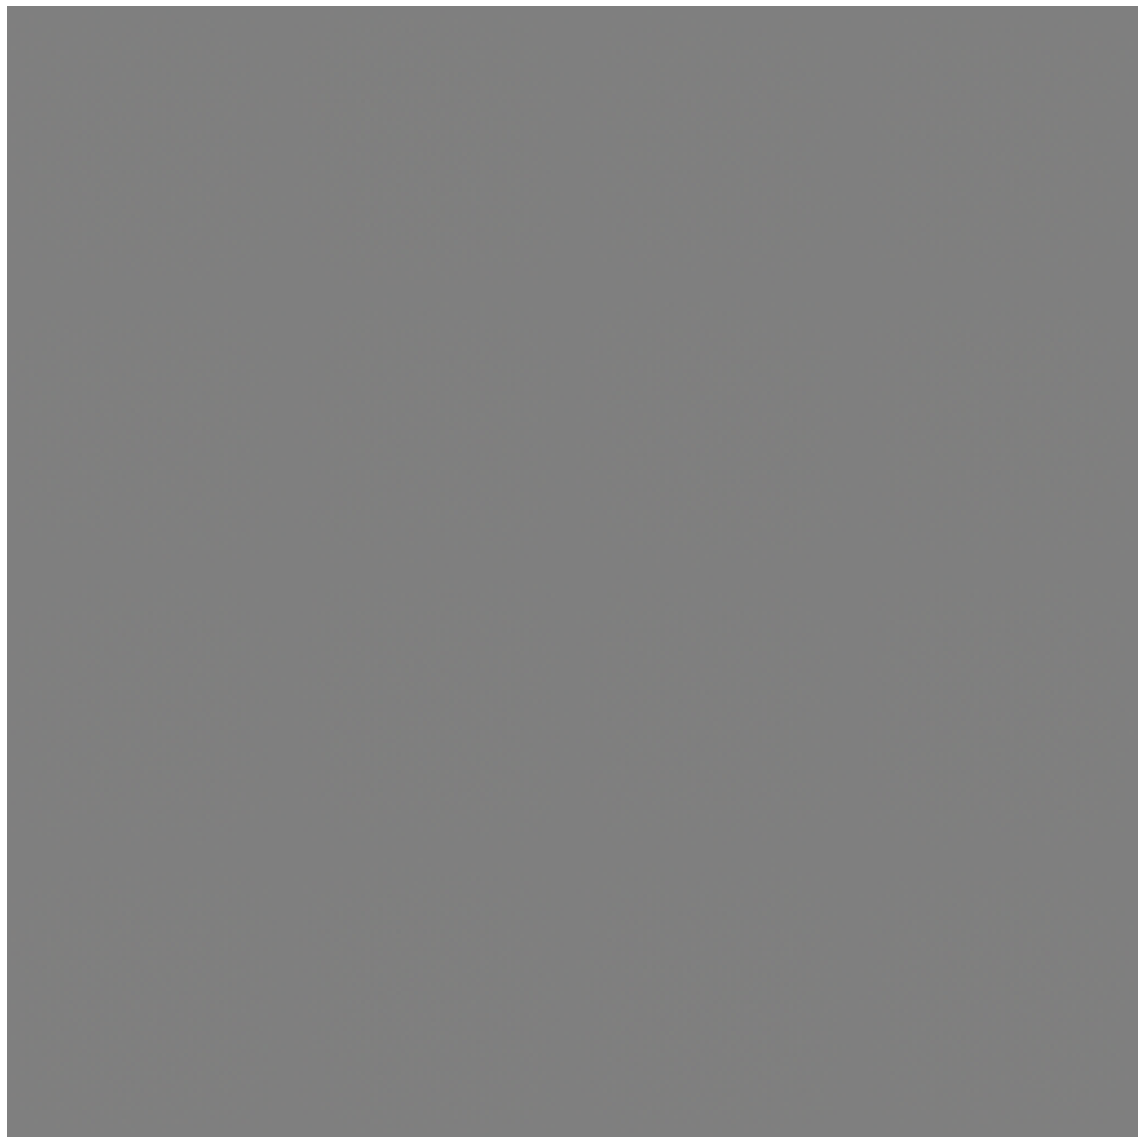

Disc: real loss: 0.766529 fake loss: 2.513596
GAN loss: 2.096197
Step 0 completed. Time took: 8 secs.
Begin step:  1
Disc: real loss: 0.742021 fake loss: 0.371458
GAN loss: 3.583829
Step 1 completed. Time took: 0 secs.
Begin step:  2
Disc: real loss: 1.716422 fake loss: 0.617738
GAN loss: 2.999268
Step 2 completed. Time took: 0 secs.
Begin step:  3
Disc: real loss: 1.015748 fake loss: 0.440694
GAN loss: 3.328906
Step 3 completed. Time took: 0 secs.
Begin step:  4
Disc: real loss: 0.896947 fake loss: 0.339906
GAN loss: 2.945279
Step 4 completed. Time took: 0 secs.
Begin step:  5
Disc: real loss: 0.510350 fake loss: 0.481163
GAN loss: 4.082108
Step 5 completed. Time took: 0 secs.
Begin step:  6
Disc: real loss: 1.196018 fake loss: 0.380615
GAN loss: 3.354599
Step 6 completed. Time took: 0 secs.
Begin step:  7
Disc: real loss: 0.942522 fake loss: 0.541495
GAN loss: 4.551364
Step 7 completed. Time took: 0 secs.
Begin step:  8
Disc: real loss: 0.728202 fake loss: 0.461924
GAN loss: 3.234604

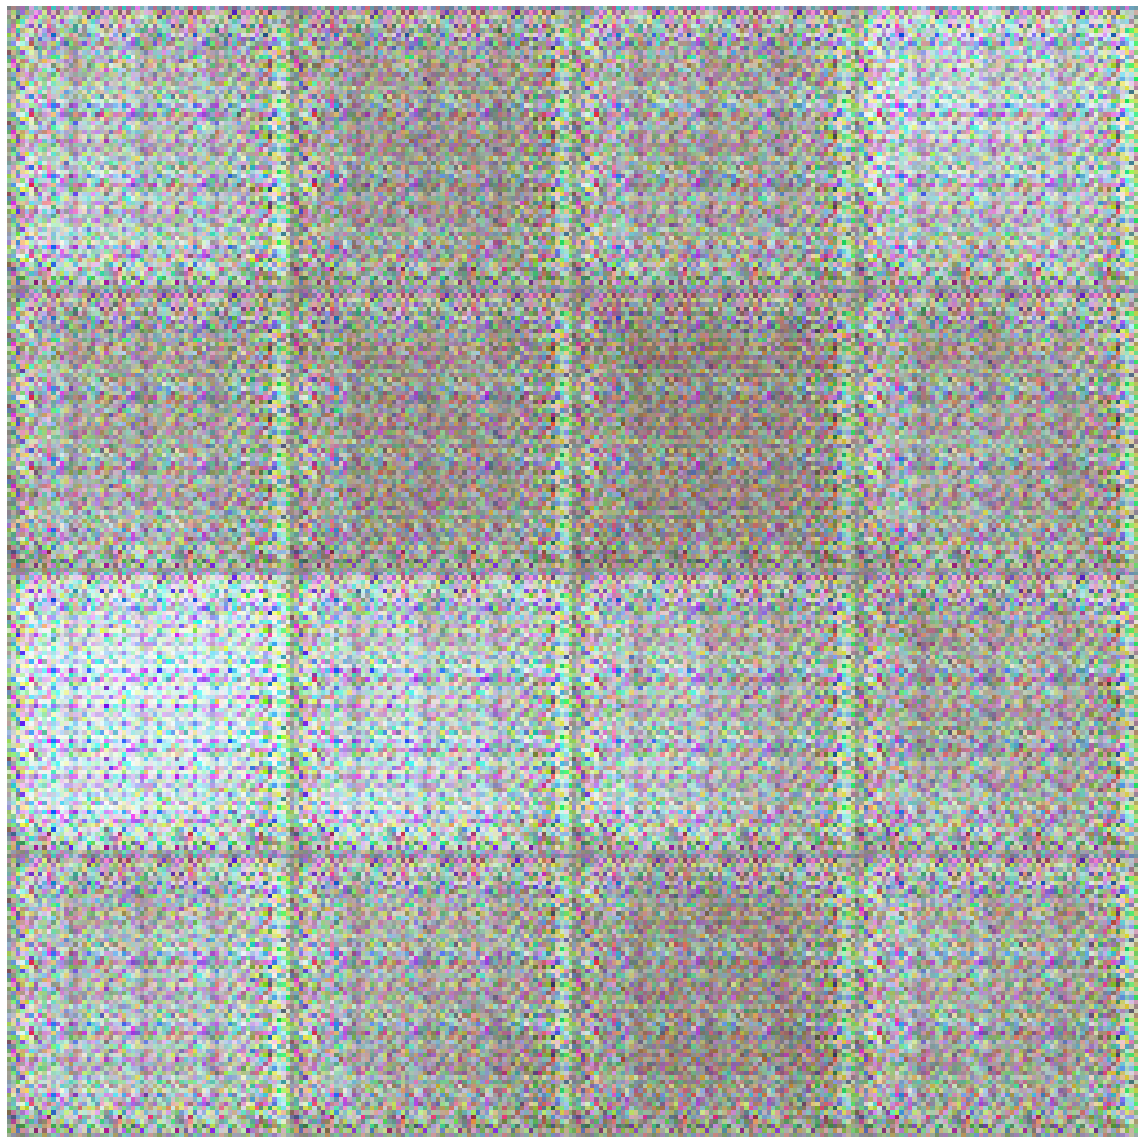

Disc: real loss: 0.306108 fake loss: 0.329418
GAN loss: 2.502863
Step 100 completed. Time took: 1 secs.
Begin step:  101
Disc: real loss: 0.324145 fake loss: 0.308857
GAN loss: 2.317259
Step 101 completed. Time took: 0 secs.
Begin step:  102
Disc: real loss: 0.319611 fake loss: 0.365376
GAN loss: 2.114096
Step 102 completed. Time took: 0 secs.
Begin step:  103
Disc: real loss: 0.312604 fake loss: 0.334581
GAN loss: 2.971354
Step 103 completed. Time took: 0 secs.
Begin step:  104
Disc: real loss: 0.341368 fake loss: 0.374978
GAN loss: 1.597240
Step 104 completed. Time took: 0 secs.
Begin step:  105
Disc: real loss: 0.385651 fake loss: 0.547046
GAN loss: 6.054469
Step 105 completed. Time took: 0 secs.
Begin step:  106
Disc: real loss: 0.499795 fake loss: 0.692098
GAN loss: 5.077579
Step 106 completed. Time took: 0 secs.
Begin step:  107
Disc: real loss: 0.345273 fake loss: 0.380179
GAN loss: 2.234796
Step 107 completed. Time took: 0 secs.
Begin step:  108
Disc: real loss: 0.390217 fake l

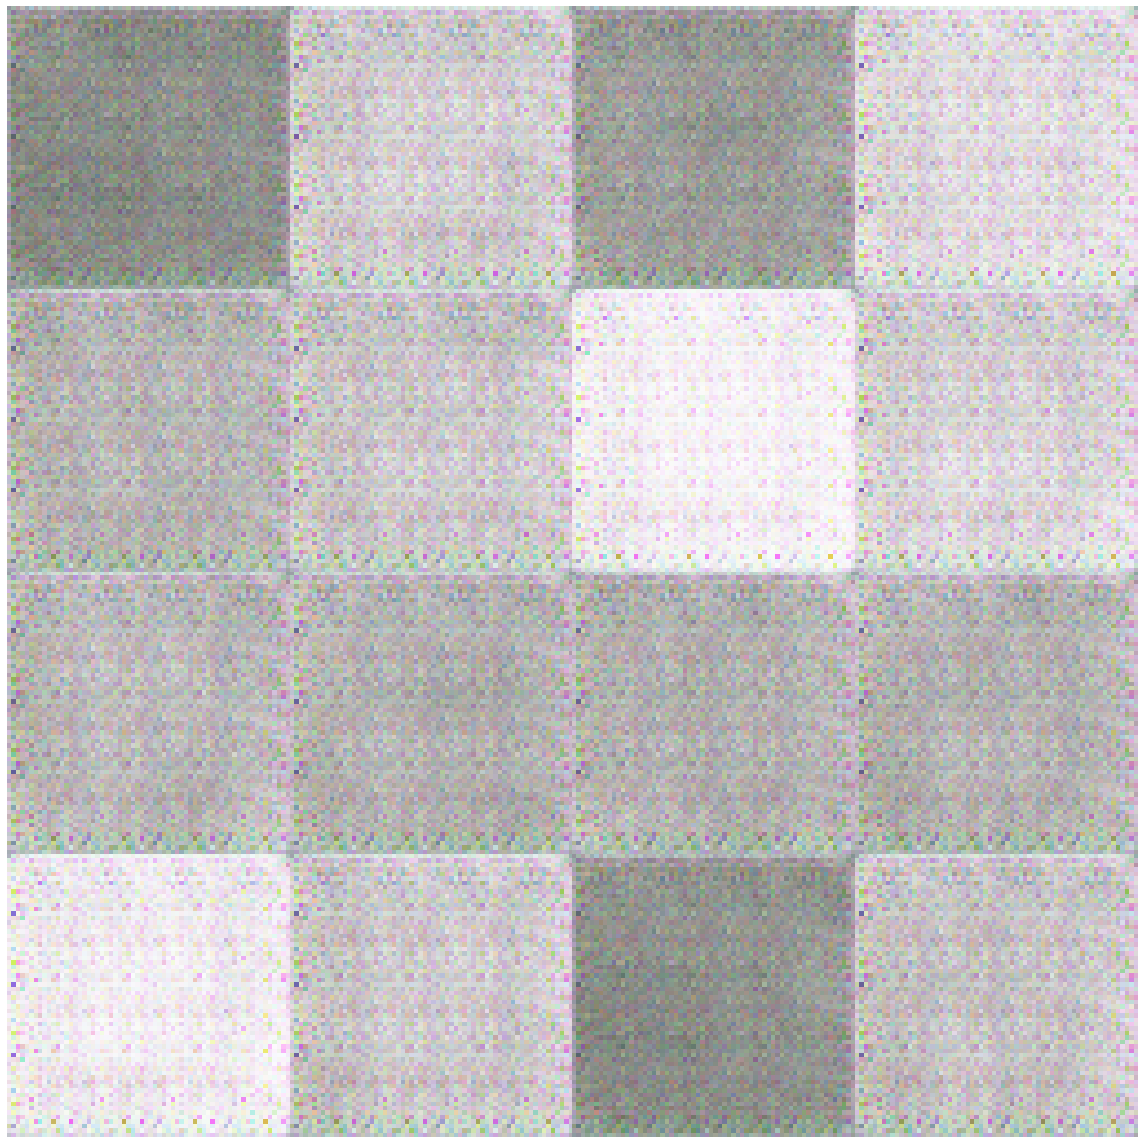

Disc: real loss: 0.321681 fake loss: 0.321369
GAN loss: 2.260527
Step 200 completed. Time took: 1 secs.
Begin step:  201
Disc: real loss: 0.334220 fake loss: 0.302282
GAN loss: 2.251567
Step 201 completed. Time took: 0 secs.
Begin step:  202
Disc: real loss: 0.343304 fake loss: 0.334892
GAN loss: 2.181246
Step 202 completed. Time took: 0 secs.
Begin step:  203
Disc: real loss: 0.325544 fake loss: 0.359124
GAN loss: 2.896171
Step 203 completed. Time took: 0 secs.
Begin step:  204
Disc: real loss: 0.327201 fake loss: 0.377629
GAN loss: 1.974611
Step 204 completed. Time took: 0 secs.
Begin step:  205
Disc: real loss: 0.391910 fake loss: 0.356034
GAN loss: 2.345922
Step 205 completed. Time took: 0 secs.
Begin step:  206
Disc: real loss: 0.363844 fake loss: 0.344299
GAN loss: 2.728722
Step 206 completed. Time took: 0 secs.
Begin step:  207
Disc: real loss: 0.380905 fake loss: 0.378148
GAN loss: 2.207848
Step 207 completed. Time took: 0 secs.
Begin step:  208
Disc: real loss: 0.490049 fake l

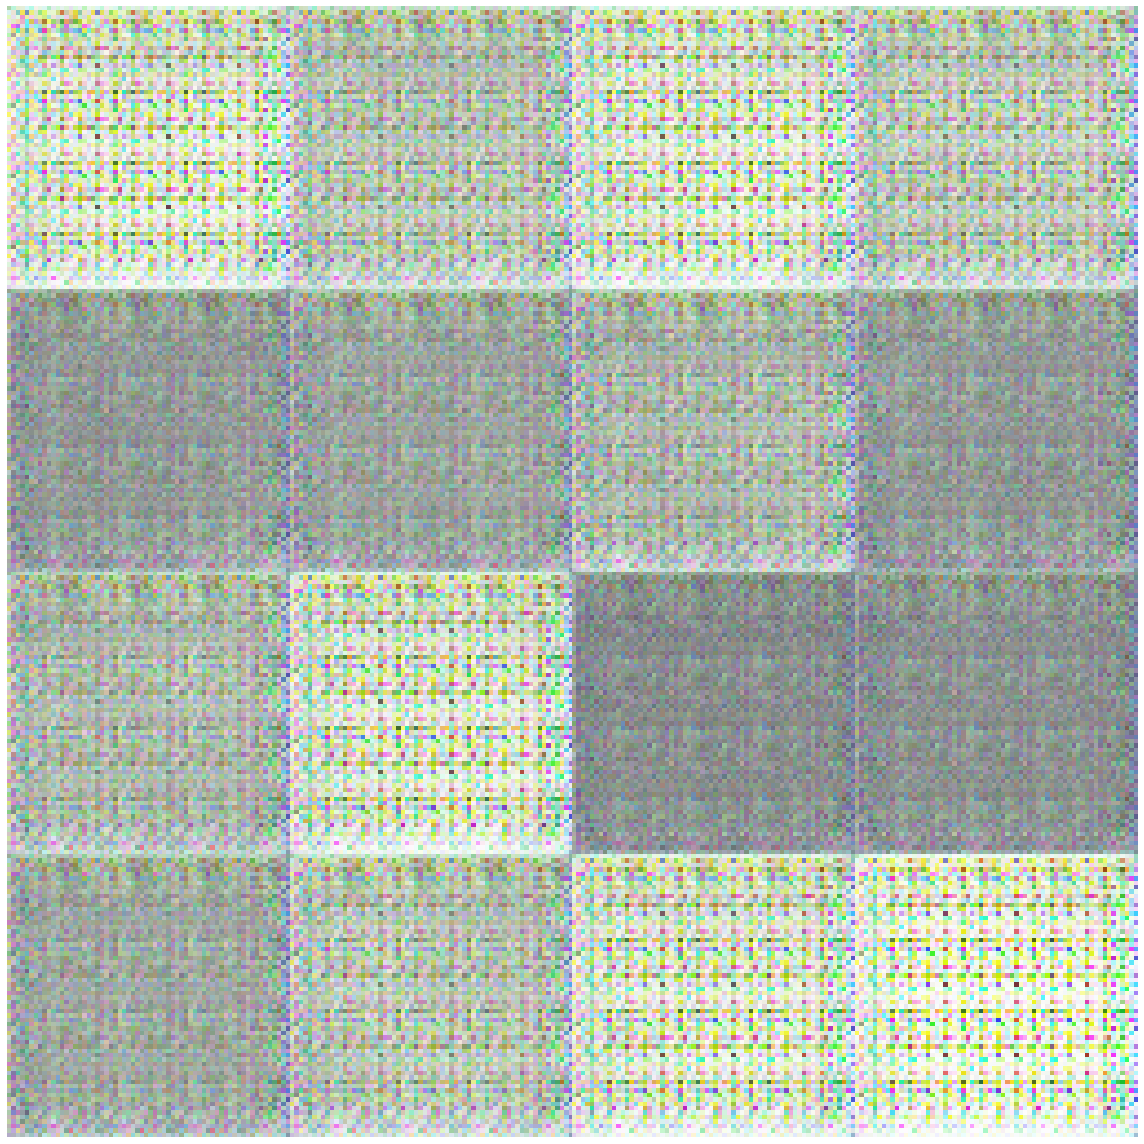

Disc: real loss: 0.384307 fake loss: 0.333881
GAN loss: 1.889298
Step 300 completed. Time took: 1 secs.
Begin step:  301
Disc: real loss: 0.424962 fake loss: 0.340464
GAN loss: 2.401416
Step 301 completed. Time took: 0 secs.
Begin step:  302
Disc: real loss: 0.389878 fake loss: 0.354744
GAN loss: 2.567564
Step 302 completed. Time took: 0 secs.
Begin step:  303
Disc: real loss: 0.310843 fake loss: 0.350931
GAN loss: 2.131411
Step 303 completed. Time took: 0 secs.
Begin step:  304
Disc: real loss: 0.385598 fake loss: 0.351902
GAN loss: 2.339662
Step 304 completed. Time took: 0 secs.
Begin step:  305
Disc: real loss: 0.322163 fake loss: 0.341626
GAN loss: 2.117539
Step 305 completed. Time took: 0 secs.
Begin step:  306
Disc: real loss: 0.331731 fake loss: 0.338429
GAN loss: 1.969424
Step 306 completed. Time took: 0 secs.
Begin step:  307
Disc: real loss: 0.380384 fake loss: 0.345406
GAN loss: 2.120565
Step 307 completed. Time took: 0 secs.
Begin step:  308
Disc: real loss: 0.354302 fake l

In [0]:
# Use a fixed noise vector to see how the GAN Images transition through time on a fixed noise. 
fixed_noise = gen_noise(16, noise_shape)

# To keep Track of losses
avg_disc_fake_loss = []
avg_disc_real_loss = []
avg_GAN_loss = []

# We will run for num_steps iterations
for step in range(num_steps): 
    tot_step = step
    print("Begin step: ", tot_step)
    # to keep track of time per step
    step_begin_time = time.time() 
    
    # sample a batch of normalized images from the dataset
    real_data_X = sample_from_dataset(batch_size, image_shape, training_data)
    
    # Genearate noise to send as input to the generator
    noise = gen_noise(batch_size, noise_shape)
    
    # Use generator to create(predict) images
    fake_data_X = generator.predict(noise)
    
    # Save predicted images from the generator every 10th step
    if (tot_step % 100) == 0:
        step_num = str(tot_step).zfill(4)
        save_img_batch(fake_data_X,img_save_dir+step_num+"_image.png")
    
    # Create the labels for real and fake data. We don't give exact ones and zeros but add a small amount of noise. This is an important GAN training trick
    real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
    fake_data_Y = np.random.random_sample(batch_size)*0.2
        
    # train the discriminator using data and labels

    discriminator.trainable = True
    generator.trainable = False

    # Training Discriminator seperately on real data
    dis_metrics_real = discriminator.train_on_batch(real_data_X, real_data_Y) 
    # training Discriminator seperately on fake data
    dis_metrics_fake = discriminator.train_on_batch(fake_data_X, fake_data_Y) 
    
    print("Disc: real loss: %f fake loss: %f" % (dis_metrics_real[0], dis_metrics_fake[0]))
    
    # Save the losses to plot later
    avg_disc_fake_loss.append(dis_metrics_fake[0])
    avg_disc_real_loss.append(dis_metrics_real[0])
    
    # Train the generator using a random vector of noise and its labels (1's with noise)
    generator.trainable = True
    discriminator.trainable = False

    GAN_X = gen_noise(batch_size, noise_shape)
    GAN_Y = real_data_Y
   
    gan_metrics = gan.train_on_batch(GAN_X,GAN_Y)
    print("GAN loss: %f" % (gan_metrics[0]))
    
    # Log results by opening a file in append mode
    text_file = open(log_dir+"\\training_log.txt", "a")
    text_file.write("Step: %d Disc: real loss: %f fake loss: %f GAN loss: %f\n" % (tot_step, dis_metrics_real[0], dis_metrics_fake[0],gan_metrics[0]))
    text_file.close()

    # save GAN loss to plot later
    avg_GAN_loss.append(gan_metrics[0])
            
    end_time = time.time()
    diff_time = int(end_time - step_begin_time)
    print("Step %d completed. Time took: %s secs." % (tot_step, diff_time))
    
    # save model at every 500 steps
    if ((tot_step+1) % 500) == 0:
        print("-----------------------------------------------------------------")
        print("Average Disc_fake loss: %f" % (np.mean(avg_disc_fake_loss))) 
        print("Average Disc_real loss: %f" % (np.mean(avg_disc_real_loss))) 
        print("Average GAN loss: %f" % (np.mean(avg_GAN_loss)))
        print("-----------------------------------------------------------------")
        discriminator.trainable = False
        generator.trainable = False
        # predict on fixed_noise
        fixed_noise_generate = generator.predict(noise)
        step_num = str(tot_step).zfill(4)
        save_img_batch(fixed_noise_generate,img_save_dir+step_num+"fixed_image.png")
        generator.save(save_model_dir+str(tot_step)+"_GENERATOR_weights_and_arch.hdf5")
        discriminator.save(save_model_dir+str(tot_step)+"_DISCRIMINATOR_weights_and_arch.hdf5")

In [0]:
def generate_images(generator, save_dir):
    noise = gen_noise(batch_size,noise_shape)
    fake_data_X = generator.predict(noise)
    print("Displaying generated images")
    plt.figure(figsize=(16,16))
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=0, hspace=0)
    rand_indices = np.random.choice(fake_data_X.shape[0],16,replace=False)
    for i in range(16):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        rand_index = rand_indices[i]
        image = fake_data_X[rand_index, :,:,:]
        fig = plt.imshow(denorm_img(image))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig(save_dir+str(time.time())+"_GENERATEDimage.png",bbox_inches='tight',pad_inches=0)
    plt.show()

generate_images(generator, img_save_dir)